# Business and Data Understanding

## Airports Weather Data 2016

### Import Airports and their latitude/longitude. 10 US airports with the most weather related delays

In [7]:
from pyspark.sql import SQLContext
import numpy as np

In [8]:

from io import StringIO
import requests
import json
import pandas as pd

# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_b12280b012b94907ad8decb8341d8375(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_fa75ff3d05c0b00bdf62f0536608f1ca7c52af71','domain': {'id': 'daf5d7dceca34848ae07708c68826bb2'},
            'password': 'ng[~3U24rFuL)UUm'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

airport_lat_long_data = pd.read_csv(get_object_storage_file_with_credentials_b12280b012b94907ad8decb8341d8375('FlightCancellation', 'airports lat long.csv'))
airport_lat_long_data.head()


,Airport,Lat,Lon
0,BOS,42.365613,-71.009560
1,DEN,39.878664,-104.682105
2,DFW,32.899809,-97.040335
3,EWR,40.689531,-74.174462
4,IAH,29.990219,-95.336782


In [9]:
airport_lat_long_data.dtypes

Airport     object
Lat        float64
Lon        float64
dtype: object

### Change column names for merging with weather data

In [10]:
airport_lat_long_data=airport_lat_long_data.rename(columns = {'Lat':'inputLatitude','Lon':'inputLongitude'})
airport_lat_long_data.head(1)

,Airport,inputLatitude,inputLongitude
0,BOS,42.365613,-71.00956


### Import weather data. Historical hourly weather data for 10 airports over the year 2016

In [11]:
weather_exported = pd.read_csv(get_object_storage_file_with_credentials_b12280b012b94907ad8decb8341d8375('FlightCancellation', 'weather_exported.csv'))

In [12]:
weather_exported.dtypes

inputLatitude                                    float64
inputLongitude                                   float64
SiteId                                           float64
Latitude                                         float64
Longitude                                        float64
DateHrGmt                                         object
DateHrLwt                                         object
SurfaceTemperatureFahrenheit                     float64
SurfaceDewpointTemperatureFahrenheit             float64
SurfaceWetBulbTemperatureFahrenheit              float64
RelativeHumidityPercent                          float64
SurfaceAirPressureMillibars                      float64
CloudCoveragePercent                             float64
WindChillTemperatureFahrenheit                   float64
ApparentTemperatureFahrenheit                    float64
WindSpeedMph                                     float64
WindDirectionDegrees                             float64
PrecipitationPreviousHourInches

In [13]:
weather_exported.head(2)

,inputLatitude,inputLongitude,SiteId,Latitude,Longitude,DateHrGmt,DateHrLwt,SurfaceTemperatureFahrenheit,SurfaceDewpointTemperatureFahrenheit,SurfaceWetBulbTemperatureFahrenheit,...,MslPressureMillibars,HeatIndexFahrenheit,SnowfallInches,SurfaceWindGustsMph,PotentialEvapotranspirationMicrometersPerHour,SurfaceWaterRunOffMillimeters,TenToFortyLiquidSoilMoisturePercent,TenToFortySoilTemperatureFahrenheit,ZeroToTenLiquidSoilMoisturePercent,ZeroToTenSoilTemperatureFahrenheit
0,37.615223,-122.389977,2180519862,37.616,-122.235,01/01/2016 00:00:00,12/31/2015 16:00:00,47.4,35.2,41.7,...,1022,47.4,0,25.0,66.000,0.001,31.600,41.200,31.300,38.100
1,37.615223,-122.389977,2180519862,37.616,-122.235,01/01/2016 01:00:00,12/31/2015 17:00:00,42.8,34.2,38.9,...,1022,42.8,0,26.3,12.000,0.001,31.600,41.000,31.300,39.000


### Derive new date and hour columns

In [14]:
weather_exported['FL_DATE'] = weather_exported.DateHrLwt.str.slice(6, 10) + weather_exported.DateHrLwt.str.slice(0, 2) + weather_exported.DateHrLwt.str.slice(3, 5)
weather_exported['Hour'] = weather_exported.DateHrLwt.str.slice(11, 13)

In [15]:
weather_exported['Hour'] = weather_exported.Hour.astype('int')

In [16]:
weather_exported.head(1)

,inputLatitude,inputLongitude,SiteId,Latitude,Longitude,DateHrGmt,DateHrLwt,SurfaceTemperatureFahrenheit,SurfaceDewpointTemperatureFahrenheit,SurfaceWetBulbTemperatureFahrenheit,...,SnowfallInches,SurfaceWindGustsMph,PotentialEvapotranspirationMicrometersPerHour,SurfaceWaterRunOffMillimeters,TenToFortyLiquidSoilMoisturePercent,TenToFortySoilTemperatureFahrenheit,ZeroToTenLiquidSoilMoisturePercent,ZeroToTenSoilTemperatureFahrenheit,FL_DATE,Hour
0,37.615223,-122.389977,2180519862,37.616,-122.235,01/01/2016 00:00:00,12/31/2015 16:00:00,47.4,35.2,41.7,...,0,25,66.000,0.001,31.600,41.200,31.300,38.100,20151231,16


In [17]:
airports_weather_df = pd.merge(weather_exported, airport_lat_long_data,  how='left', left_on=['inputLatitude','inputLongitude'], right_on = ['inputLatitude','inputLongitude'])

#### Drop columns that aren't features

In [18]:
airports_weather_df.drop(['SiteId','Latitude','Longitude','inputLatitude','inputLongitude','DateHrGmt','DateHrLwt','SurfaceDewpointTemperatureFahrenheit','SurfaceWetBulbTemperatureFahrenheit','RelativeHumidityPercent',
                'SurfaceAirPressureMillibars','WindChillTemperatureFahrenheit','ApparentTemperatureFahrenheit','WindDirectionDegrees',
               'DownwardSolarRadiationWsqm','DiffuseHorizontalRadiationWsqm','DirectNormalIrradianceWsqm','MslPressureMillibars',
               'HeatIndexFahrenheit','PotentialEvapotranspirationMicrometersPerHour','TenToFortyLiquidSoilMoisturePercent',
               'TenToFortySoilTemperatureFahrenheit','ZeroToTenLiquidSoilMoisturePercent','ZeroToTenSoilTemperatureFahrenheit'], axis=1,inplace='True')
airports_weather_df.head(1)

,SurfaceTemperatureFahrenheit,CloudCoveragePercent,WindSpeedMph,PrecipitationPreviousHourInches,SnowfallInches,SurfaceWindGustsMph,SurfaceWaterRunOffMillimeters,FL_DATE,Hour,Airport
0,47.4,0,5.8,0,0,25,0.001,20151231,16,SFO


## Airports Flight Data 2016

### Retrieve historical flights data for all US airports over the year 2016

In [19]:
Jan2016_df = pd.read_csv(get_object_storage_file_with_credentials_b12280b012b94907ad8decb8341d8375('FlightCancellation', 'Jan 2016 Flights.csv'))
Jan2016_df.head(1)

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,5,2016-01-01,HA,18,HNL,LAS,1605,1601,-4,16,...,NaN,335,310,283,2762,NaN,NaN,NaN,NaN,NaN


In [20]:
Feb2016_df = pd.read_csv(get_object_storage_file_with_credentials_b12280b012b94907ad8decb8341d8375('FlightCancellation', 'Feb 2016 Flights.csv'))
Feb2016_df.head(1)

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1,2016-02-01,DL,1592,SAN,ATL,615,614,-1,22,...,NaN,250,229,202,1892,NaN,NaN,NaN,NaN,NaN


In [21]:
Mar2016_df = pd.read_csv(get_object_storage_file_with_credentials_b12280b012b94907ad8decb8341d8375('FlightCancellation', 'Mar 2016 Flights.csv'))
Mar2016_df.head(1)

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1,2016-03-07,AA,1,JFK,LAX,900,918,18,19,...,NaN,394,361,332,2475,NaN,NaN,NaN,NaN,NaN


In [22]:
Apr2016_df = pd.read_csv(get_object_storage_file_with_credentials_b12280b012b94907ad8decb8341d8375('FlightCancellation', 'Apr 2016 Flights.csv'))
Apr2016_df.head(1)

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1,2016-04-04,AA,1,JFK,LAX,900,902,2,15,...,NaN,394,367,345,2475,NaN,NaN,NaN,NaN,NaN


In [23]:
May2016_df = pd.read_csv(get_object_storage_file_with_credentials_b12280b012b94907ad8decb8341d8375('FlightCancellation', 'May 2016 Flights.csv'))
May2016_df.head(1)

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,7,2016-05-08,WN,290,DAL,AUS,1730,1746,16,9,...,NaN,50,47,35,189,NaN,NaN,NaN,NaN,NaN


In [24]:
Jun2016_df = pd.read_csv(get_object_storage_file_with_credentials_b12280b012b94907ad8decb8341d8375('FlightCancellation', 'Jun 2016 Flights.csv'))
Jun2016_df.head(1)

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1,2016-06-06,AA,1,BOS,JFK,600,1155,355,31,...,NaN,71,86,44,187,355,0,15,0,0


In [25]:
Jul2016_df = pd.read_csv(get_object_storage_file_with_credentials_b12280b012b94907ad8decb8341d8375('FlightCancellation', 'Jul 2016 Flights.csv'))
Jul2016_df.head(1)

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,5,2016-07-15,B6,954,SJU,FLL,515,513,-2,12,...,NaN,156,159,139,1046,NaN,NaN,NaN,NaN,NaN


In [26]:
Aug2016_df = pd.read_csv(get_object_storage_file_with_credentials_b12280b012b94907ad8decb8341d8375('FlightCancellation', 'Aug 2016 Flights.csv'))
Aug2016_df.head(1)

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1,2016-08-08,DL,409,SFO,JFK,1245,1458,133,14,...,NaN,345,309,280,2586,0,0,5,0,92


In [27]:
Sep2016_df = pd.read_csv(get_object_storage_file_with_credentials_b12280b012b94907ad8decb8341d8375('FlightCancellation', 'Sep 2016 Flights.csv'))
Sep2016_df.head(1)

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1,2016-09-12,AA,1,BOS,JFK,600,632,32,21,...,NaN,75,62,37,187,19,0,0,0,0


In [28]:
Oct2016_df = pd.read_csv(get_object_storage_file_with_credentials_b12280b012b94907ad8decb8341d8375('FlightCancellation', 'Oct 2016 Flights.csv'))
Oct2016_df.head(1)

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1,2016-10-10,HA,24,OGG,OAK,1130,1129,-1,16,...,NaN,300,301,273,2349,NaN,NaN,NaN,NaN,NaN


In [29]:
Nov2016_df = pd.read_csv(get_object_storage_file_with_credentials_b12280b012b94907ad8decb8341d8375('FlightCancellation', 'Nov 2016 Flights.csv'))
Nov2016_df.head(1)

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1,2016-11-07,AA,1,JFK,LAX,800,758,-2,25,...,NaN,402,347,300,2475,NaN,NaN,NaN,NaN,NaN


In [30]:
Dec2016_df = pd.read_csv(get_object_storage_file_with_credentials_b12280b012b94907ad8decb8341d8375('FlightCancellation', 'Dec 2016 Flights.csv'))
Dec2016_df.head(1)

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1,2016-12-05,DL,388,DTW,DCA,725,725,0,16,...,NaN,92,86,67,405,NaN,NaN,NaN,NaN,NaN


In [31]:
frames = [Jan2016_df, Feb2016_df, Mar2016_df, Apr2016_df, May2016_df, Jun2016_df, Jul2016_df, Aug2016_df, Sep2016_df, Oct2016_df,
         Nov2016_df, Dec2016_df]

airport_flights_df = pd.concat(frames)

In [32]:
airport_flights_df.head(1)

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,5,2016-01-01,HA,18,HNL,LAS,1605,1601,-4,16,...,NaN,335,310,283,2762,NaN,NaN,NaN,NaN,NaN


In [33]:
airport_flights_df.shape

(5332113, 26)

### Select 10 airports

In [34]:
airport_flights_df = airport_flights_df[(airport_flights_df.ORIGIN == "BOS") | (airport_flights_df.ORIGIN == "EWR") | (airport_flights_df.ORIGIN == "JFK") | (airport_flights_df.ORIGIN == "LGA") | (airport_flights_df.ORIGIN == "ORD") | (airport_flights_df.ORIGIN == "DEN") | (airport_flights_df.ORIGIN == "DFW") | (airport_flights_df.ORIGIN == "IAH") | (airport_flights_df.ORIGIN == "PHL") | (airport_flights_df.ORIGIN == "SFO")]  

In [35]:
airport_flights_df = airport_flights_df[(airport_flights_df.DEST == "BOS") | (airport_flights_df.DEST == "EWR") | (airport_flights_df.DEST == "JFK") | (airport_flights_df.DEST == "LGA") | (airport_flights_df.DEST == "ORD") | (airport_flights_df.DEST == "DEN") | (airport_flights_df.DEST == "DFW") | (airport_flights_df.DEST == "IAH") | (airport_flights_df.DEST == "PHL") | (airport_flights_df.DEST == "SFO")]

In [36]:
airport_flights_df.shape

(317718, 26)

#### Derive the Hour from the scheduled departure time

In [37]:
airport_flights_df['Hour'] = airport_flights_df.CRS_DEP_TIME / 100

In [38]:
airport_flights_df['Hour'] = airport_flights_df.Hour.astype(int)

In [39]:
airport_flights_df.head(2)

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Hour
228,5,2016-01-01,NK,224,ORD,LGA,546,NaN,NaN,NaN,...,124,NaN,NaN,733,NaN,NaN,NaN,NaN,NaN,5
319,5,2016-01-01,NK,331,LGA,ORD,2159,2140,-19,10,...,148,129,111,733,NaN,NaN,NaN,NaN,NaN,21


#### Change FL_DATE format to match airport_weather_df FL_DATE format

In [40]:
airport_flights_df.FL_DATE = airport_flights_df.FL_DATE.str.replace('-', '')

In [41]:
airport_flights_df.head(1)

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Hour
228,5,20160101,NK,224,ORD,LGA,546,NaN,NaN,NaN,...,124,NaN,NaN,733,NaN,NaN,NaN,NaN,NaN,5


#### Drop columns that aren't needed as features

In [42]:
airport_flights_df.drop(['DEP_TIME','DEP_DELAY','TAXI_OUT','WHEELS_ON','TAXI_IN','ARR_TIME','ARR_DELAY','ACTUAL_ELAPSED_TIME',
                          'AIR_TIME','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY', 'CRS_ELAPSED_TIME',
                        'CRS_DEP_TIME','CRS_ARR_TIME'], axis=1,inplace='True')

In [43]:
airport_flights_df.dtypes

DAY_OF_WEEK           int64
FL_DATE              object
UNIQUE_CARRIER       object
FL_NUM                int64
ORIGIN               object
DEST                 object
CANCELLED             int64
CANCELLATION_CODE    object
DISTANCE              int64
Hour                  int64
dtype: object

In [44]:
airport_flights_df.shape

(317718, 10)

### Rename feature columns in the weather dataframe for merging with flight dataframe. This will add weather data for the ORIGIN airport

In [45]:
airports_weather_df.rename(columns={'Airport':'ORIGIN','SurfaceTemperatureFahrenheit':'O_SurfaceTemperatureFahrenheit',
                                   'CloudCoveragePercent':'O_CloudCoveragePercent','WindSpeedMph':'O_WindSpeedMph',
                                    'PrecipitationPreviousHourInches':'O_PrecipitationPreviousHourInches','SnowfallInches':'O_SnowfallInches',
                                   'SurfaceWindGustsMph':'O_SurfaceWindGustsMph','SurfaceWaterRunOffMillimeters':'O_SurfaceWaterRunOffMillimeters'}, inplace=True)

In [46]:
airports_weather_df.dtypes

O_SurfaceTemperatureFahrenheit       float64
O_CloudCoveragePercent               float64
O_WindSpeedMph                       float64
O_PrecipitationPreviousHourInches    float64
O_SnowfallInches                     float64
O_SurfaceWindGustsMph                float64
O_SurfaceWaterRunOffMillimeters       object
FL_DATE                               object
Hour                                   int64
ORIGIN                                object
dtype: object

In [47]:
airports_weather_df.head(1)

,O_SurfaceTemperatureFahrenheit,O_CloudCoveragePercent,O_WindSpeedMph,O_PrecipitationPreviousHourInches,O_SnowfallInches,O_SurfaceWindGustsMph,O_SurfaceWaterRunOffMillimeters,FL_DATE,Hour,ORIGIN
0,47.4,0,5.8,0,0,25,0.001,20151231,16,SFO


In [48]:
flights_with_weather_df = pd.merge(airport_flights_df,airports_weather_df,on=['FL_DATE','Hour','ORIGIN'])

In [49]:
flights_with_weather_df.dtypes

DAY_OF_WEEK                            int64
FL_DATE                               object
UNIQUE_CARRIER                        object
FL_NUM                                 int64
ORIGIN                                object
DEST                                  object
CANCELLED                              int64
CANCELLATION_CODE                     object
DISTANCE                               int64
Hour                                   int64
O_SurfaceTemperatureFahrenheit       float64
O_CloudCoveragePercent               float64
O_WindSpeedMph                       float64
O_PrecipitationPreviousHourInches    float64
O_SnowfallInches                     float64
O_SurfaceWindGustsMph                float64
O_SurfaceWaterRunOffMillimeters       object
dtype: object

In [50]:
flights_with_weather_df.shape

(316928, 17)

### Rename feature columns in the weather dataframe for merging with flight dataframe. This will add weather data for the DESTINATION airport

In [51]:
airports_weather_df.rename(columns={'ORIGIN':'DEST','O_SurfaceTemperatureFahrenheit':'D_SurfaceTemperatureFahrenheit',
                                   'O_CloudCoveragePercent':'D_CloudCoveragePercent','O_WindSpeedMph':'D_WindSpeedMph',
                                    'O_PrecipitationPreviousHourInches':'D_PrecipitationPreviousHourInches','O_SnowfallInches':'D_SnowfallInches',
                                   'O_SurfaceWindGustsMph':'D_SurfaceWindGustsMph','O_SurfaceWaterRunOffMillimeters':'D_SurfaceWaterRunOffMillimeters'}, inplace=True)

In [52]:
airports_weather_df.dtypes

D_SurfaceTemperatureFahrenheit       float64
D_CloudCoveragePercent               float64
D_WindSpeedMph                       float64
D_PrecipitationPreviousHourInches    float64
D_SnowfallInches                     float64
D_SurfaceWindGustsMph                float64
D_SurfaceWaterRunOffMillimeters       object
FL_DATE                               object
Hour                                   int64
DEST                                  object
dtype: object

In [53]:
flights_with_weather_df = pd.merge(flights_with_weather_df,airports_weather_df,on=['FL_DATE','Hour','DEST'])

### Let's use pixiedust to see what it can do

In [54]:
import pixiedust
display(flights_with_weather_df)

DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,CANCELLED,DISTANCE,Hour,O_SurfaceTemperatureFahrenheit,O_CloudCoveragePercent,O_WindSpeedMph,O_PrecipitationPreviousHourInches,O_SnowfallInches,O_SurfaceWindGustsMph,O_SurfaceWaterRunOffMillimeters,D_SurfaceTemperatureFahrenheit,D_CloudCoveragePercent,D_WindSpeedMph,D_PrecipitationPreviousHourInches,D_SnowfallInches,D_SurfaceWindGustsMph,D_SurfaceWaterRunOffMillimeters
5,20160101,UA,ORD,DEN,0,888,5,20.9,99.0,15.3,0.0,0.0,36.2,0.001,7.8,0.0,6.0,0.0,0.0,9.9,0.0
5,20160101,UA,SFO,DEN,0,967,5,36.3,0.0,7.8,0.0,0.0,26.1,0.0,7.8,0.0,6.0,0.0,0.0,9.9,0.0
5,20160101,UA,ORD,EWR,0,719,5,20.9,99.0,15.3,0.0,0.0,36.2,0.001,37.7,100.0,10.0,0.0,0.0,27.0,0.003
5,20160101,UA,ORD,IAH,0,925,5,20.9,99.0,15.3,0.0,0.0,36.2,0.001,45.4,99.0,10.9,0.0,0.0,21.0,0.016
5,20160101,UA,SFO,IAH,0,1635,5,36.3,0.0,7.8,0.0,0.0,26.1,0.0,45.4,99.0,10.9,0.0,0.0,21.0,0.016
5,20160101,AA,ORD,DFW,0,802,5,20.9,99.0,15.3,0.0,0.0,36.2,0.001,37.0,100.0,12.0,0.0,0.0,24.1,0.026
5,20160101,AA,BOS,DFW,0,1562,5,31.6,85.0,12.3,0.0,0.0,24.7,0.072,37.0,100.0,12.0,0.0,0.0,24.1,0.026
5,20160101,AA,SFO,DFW,0,1464,5,36.3,0.0,7.8,0.0,0.0,26.1,0.0,37.0,100.0,12.0,0.0,0.0,24.1,0.026
5,20160101,AA,SFO,DFW,0,1464,5,36.3,0.0,7.8,0.0,0.0,26.1,0.0,37.0,100.0,12.0,0.0,0.0,24.1,0.026
5,20160101,AA,DEN,DFW,0,641,5,7.8,0.0,6.0,0.0,0.0,9.9,0.0,37.0,100.0,12.0,0.0,0.0,24.1,0.026


# Data Preparation - first iteration

In [55]:
%matplotlib inline 

In [56]:
flights_with_weather_df.CANCELLATION_CODE.value_counts(sort=False, dropna=False)

NaN    312262
A        1427
B        2572
C         623
D           6
Name: CANCELLATION_CODE, dtype: int64

#### Clean up null values

In [57]:
flights_with_weather_df.isnull().sum()

DAY_OF_WEEK                               0
FL_DATE                                   0
UNIQUE_CARRIER                            0
FL_NUM                                    0
ORIGIN                                    0
DEST                                      0
CANCELLED                                 0
CANCELLATION_CODE                    312262
DISTANCE                                  0
Hour                                      0
O_SurfaceTemperatureFahrenheit            0
O_CloudCoveragePercent                    0
O_WindSpeedMph                            0
O_PrecipitationPreviousHourInches         0
O_SnowfallInches                          0
O_SurfaceWindGustsMph                     0
O_SurfaceWaterRunOffMillimeters           0
D_SurfaceTemperatureFahrenheit            0
D_CloudCoveragePercent                    0
D_WindSpeedMph                            0
D_PrecipitationPreviousHourInches         0
D_SnowfallInches                          0
D_SurfaceWindGustsMph           

#### Replace nulls with 0's

In [58]:
flights_with_weather_df['O_SurfaceWaterRunOffMillimeters'] = flights_with_weather_df['O_SurfaceWaterRunOffMillimeters'].replace(['$null$'], 0.000)
flights_with_weather_df['D_SurfaceWaterRunOffMillimeters'] = flights_with_weather_df['D_SurfaceWaterRunOffMillimeters'].replace(['$null$'], 0.000)

In [59]:
flights_with_weather_df['O_SurfaceWaterRunOffMillimeters'] = pd.to_numeric(flights_with_weather_df['O_SurfaceWaterRunOffMillimeters'], errors='coerce')
flights_with_weather_df['D_SurfaceWaterRunOffMillimeters'] = pd.to_numeric(flights_with_weather_df['D_SurfaceWaterRunOffMillimeters'], errors='coerce')

#### Filter out "non-weather" cancellations

In [60]:
calcel_code_list = ['A', 'C', 'D']
flights_with_weather_df = flights_with_weather_df.loc[~flights_with_weather_df['CANCELLATION_CODE'].isin(calcel_code_list)]

#### Drop columns not needed

In [61]:
flights_with_weather_df = flights_with_weather_df.drop(['FL_NUM','CANCELLATION_CODE'], axis=1)

#### The data is very imbalanced

In [62]:
flights_with_weather_df.CANCELLED.value_counts()

0    312301
1      2533
Name: CANCELLED, dtype: int64

#### Install libraries to use SMOTE

In [63]:
! pip install imbalanced-learn

In [65]:
import pandas as pd
from sklearn import datasets, metrics
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

#import balancing techniques
import imblearn
from imblearn.over_sampling import SMOTE

### Four feature columns will need to be converted

In [66]:
flights_with_weather_df.dtypes

DAY_OF_WEEK                            int64
FL_DATE                               object
UNIQUE_CARRIER                        object
ORIGIN                                object
DEST                                  object
CANCELLED                              int64
DISTANCE                               int64
Hour                                   int64
O_SurfaceTemperatureFahrenheit       float64
O_CloudCoveragePercent               float64
O_WindSpeedMph                       float64
O_PrecipitationPreviousHourInches    float64
O_SnowfallInches                     float64
O_SurfaceWindGustsMph                float64
O_SurfaceWaterRunOffMillimeters      float64
D_SurfaceTemperatureFahrenheit       float64
D_CloudCoveragePercent               float64
D_WindSpeedMph                       float64
D_PrecipitationPreviousHourInches    float64
D_SnowfallInches                     float64
D_SurfaceWindGustsMph                float64
D_SurfaceWaterRunOffMillimeters      float64
dtype: obj

#### Create features df and target

In [67]:
x = flights_with_weather_df
y = flights_with_weather_df['CANCELLED']
del x['CANCELLED']


In [68]:
print x.shape, y.shape

(314834, 21) (314834,)


#### Run One Hot Encoding on the four string /object features

In [69]:
cols_to_transform = [ 'FL_DATE', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST']
df_with_dummies = pd.get_dummies(x, columns = cols_to_transform )

#### One Hot Encoding expands the 4 feature columns into many more

In [70]:
print x.shape
print df_with_dummies.shape

(314834, 21)
(314834, 400)


### Creating the Training and Test Sets
ref: https://beckernick.github.io/oversampling-modeling/

In [71]:
training_features, test_features, training_target, test_target, = train_test_split(df_with_dummies, y, test_size=0.15, random_state=12)

In [72]:
print training_features.shape, test_features.shape
print training_target.shape, test_target.shape

(267608, 400) (47226, 400)
(267608,) (47226,)


#### Oversample only on the training data

In [73]:
x_train, x_val, y_train, y_val = train_test_split(training_features, training_target, test_size = .15, random_state=12)

In [74]:
sm = SMOTE(k=5, kind = 'regular', ratio='auto')
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [75]:
print training_target.value_counts(), np.bincount(y_train_res)

0    265464
1      2144
Name: CANCELLED, dtype: int64 [225662 225662]


In [76]:
clf_rf = RandomForestClassifier(n_estimators=100, random_state=12)
clf_rf.fit(x_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

Accuracy = (TP+TN) / (TP+TN+FP+FN)
Precision = TP / (TP+FP)
Recall = TP / (TP+FN)

In [77]:
print 'Validation Results'
print 'Accuracy: ', clf_rf.score(x_val, y_val)
print 'Precision:', precision_score(y_val, clf_rf.predict(x_val))
print 'Recall:', recall_score(y_val, clf_rf.predict(x_val))
print 'F1 score:', f1_score(y_val, clf_rf.predict(x_val),average='weighted')
print 'Confusion Matrix:\n', confusion_matrix(y_val, clf_rf.predict(x_val))
print '\nTest Results'
print 'Accuracy: ', clf_rf.score(test_features, test_target)
print 'Precision:', precision_score(test_target, clf_rf.predict(test_features))
print 'Recall:   ', recall_score(test_target, clf_rf.predict(test_features))
print 'F1 score:', f1_score(test_target, clf_rf.predict(test_features),average='weighted')
print 'Confusion Matrix:\n', confusion_matrix(test_target, clf_rf.predict(test_features))

Validation Results
Accuracy:  0.993996313089
Precision: 0.739130434783
Recall: 0.45
F1 score: 0.993271438615
Confusion Matrix:
[[39748    54]
 [  187   153]]

Test Results
Accuracy:  0.993795790454
Precision: 0.733009708738
Recall:    0.388174807198
F1 score: 0.992847746131
Confusion Matrix:
[[46782    55]
 [  238   151]]


In [69]:
#!pip install --user ggplot
from ggplot import *

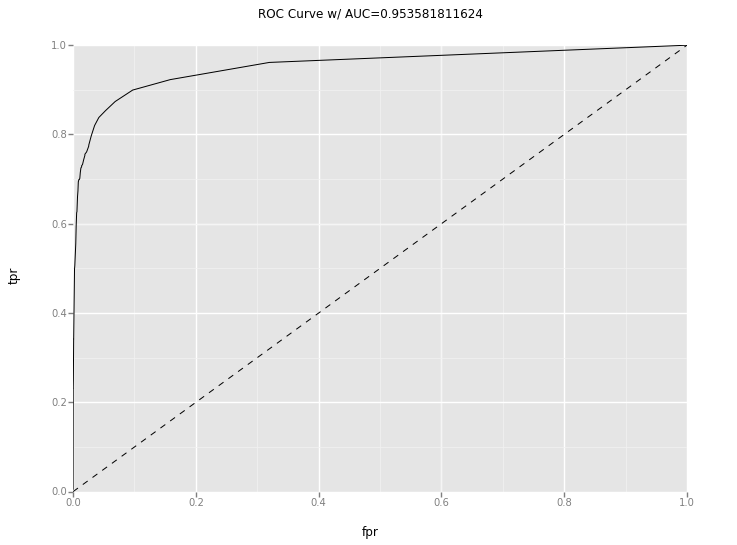

<ggplot: (8784718920409)>

In [70]:
# from http://blog.yhat.com/posts/roc-curves.html
preds = clf_rf.predict_proba(test_features)[:,1]
fpr, tpr, _ = roc_curve(test_target, preds)
auc = metrics.auc(fpr,tpr)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed') +\
    ggtitle("ROC Curve w/ AUC=%s" % str(auc))
